
> In this notebook, we use a **real biological sample** from the **[HuBMAP (Human BioMolecular Atlas Program)](https://hubmapconsortium.org/hubmap-data/)** dataset.  
> The HuBMAP dataset provides high-resolution, multimodal tissue imaging data used for studying human cellular architecture and spatial organization.


In [1]:
import tifffile
import xml.etree.ElementTree as ET
import imageio.v3 as iio
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import matplotlib.patches as patches

In [2]:
from cellSAM import cellsam_pipeline, get_model
from cellSAM.utils import format_image_shape, normalize_image

> **Dataset Used**  
> This notebook uses a real sample from the **[HuBMAP (Human BioMolecular Atlas Program)](https://hubmapconsortium.org/hubmap-data/)**.  
> Specifically, we use the **[HuBMAP Large Intestine Dataset](https://portal.hubmapconsortium.org/browse/dataset/96f5c73df89d553cda6547b508aee854?redirected=True&redirectedFromId=HBM942.WHFC.488&redirectedFromPipeline=Cytokit+%2B+SPRM#files-hbm942.whfc.488)**,  
> accessed from the following path within the data directory:
>
> `/00cc71c7e1cddac60e794044079faeee/pipeline_output/expr/`
>
> You can also explore the dataset files directly via the **[Globus File Manager link](https://app.globus.org/file-manager?origin_id=af603d86-eab9-4eec-bb1d-9d26556741bb&origin_path=%2F00cc71c7e1cddac60e794044079faeee%2Fpipeline_output%2Fexpr%2F&two_pane=false)**.


In [3]:
# Path to your file
file_path = "/u/sbdubey/CLI_HUBMAP/hra-deepcell-experiments/input-data/img_test/reg001_expr.ome.tiff"

# Read the image stack (all frames / z-slices)
img = iio.imread(file_path)

print("Image shape:", img.shape)   # e.g. (Z, Y, X) or (C, Z, Y, X)
print("Data type:", img.dtype)

Image shape: (54, 1, 9510, 9993)
Data type: uint16


In [4]:
# Get image properties / metadata
props = iio.improps(file_path)
print("\n--- Image Properties ---")
print("Shape:", props.shape)
print("dtype:", props.dtype)
print("n_images:", props.n_images)
print("is_batch:", props.is_batch)
print("spacing:", props.spacing)



--- Image Properties ---
Shape: (9510, 9993)
dtype: uint16
n_images: None
is_batch: False
spacing: (1.0, 1.0)


In [5]:
with tifffile.TiffFile(file_path) as tif:
    ome_xml = tif.ome_metadata  # raw OME-XML string

print("--- Raw OME-XML Metadata ---")
print(ome_xml[:1000], "...")  # print first 1000 characters for preview

--- Raw OME-XML Metadata ---
<?xml version='1.0' encoding='utf-8'?>
<OME xmlns="http://www.openmicroscopy.org/Schemas/OME/2016-06" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.openmicroscopy.org/Schemas/OME/2016-06 http://www.openmicroscopy.org/Schemas/OME/2016-06/ome.xsd" UUID="urn:uuid:232abd1d-9c9c-4738-9f17-bd0092791f41">
  <Image ID="Image:0" Name="default.png">
    <AcquisitionDate>2023-05-23T08:07:39.444617</AcquisitionDate>
    <Pixels DimensionOrder="XYZCT" ID="Pixels:0" SizeC="54" SizeT="1" SizeX="9993" SizeY="9510" SizeZ="1" Type="uint16" BigEndian="true" PhysicalSizeX="377.44" PhysicalSizeY="377.44" PhysicalSizeXUnit="nm" PhysicalSizeYUnit="nm">
<Channel ID="Channel:0:0" SamplesPerPixel="1" Name="Hoechst1">
        <LightPath />
      </Channel>
    <Channel ID="Channel:0:1" Name="MUC1" SamplesPerPixel="1" /><Channel ID="Channel:0:2" Name="CD25" SamplesPerPixel="1" /><Channel ID="Channel:0:3" Name="CDX2" SamplesPerPixel="1" /><Channel

In [6]:
# Parse OME-XML to extract channels
root = ET.fromstring(ome_xml)
ns = {"ome": "http://www.openmicroscopy.org/Schemas/OME/2016-06"}
channels = [c.attrib.get("Name") for c in root.findall(".//ome:Channel", ns)]

print("\nChannels:", channels)
for i, j in enumerate(channels):
    print(f"{i}, {j}")


Channels: ['Hoechst1', 'MUC1', 'CD25', 'CDX2', 'Vimentin', 'CD57', 'NKG2D', 'CD7', 'CD4', 'CD19', 'ITLN1', 'CD11c', 'CD161', 'Synaptophysin', 'CD34', 'CD16', 'CD15', 'HLADR', 'CD123', 'CD66', 'CD3', 'CD45RO', 'CD38', 'CD90', 'CD127', 'aSMA', 'CD117', 'FAP', 'MUC2', 'CHGA', 'CD68', 'CollIV', 'CD21', 'MUC6', 'CD31', 'CD56', 'CD36', 'Ki67', 'CD69', 'CD138', 'SOX9', 'CD8', 'CD49a', 'CD49f', 'CD45', 'BCL2', 'CD44', 'Podoplanin', 'Cytokeratin', 'CD163', 'OLFM4', 'CD206', 'aDefensin5', 'DRAQ5']
0, Hoechst1
1, MUC1
2, CD25
3, CDX2
4, Vimentin
5, CD57
6, NKG2D
7, CD7
8, CD4
9, CD19
10, ITLN1
11, CD11c
12, CD161
13, Synaptophysin
14, CD34
15, CD16
16, CD15
17, HLADR
18, CD123
19, CD66
20, CD3
21, CD45RO
22, CD38
23, CD90
24, CD127
25, aSMA
26, CD117
27, FAP
28, MUC2
29, CHGA
30, CD68
31, CollIV
32, CD21
33, MUC6
34, CD31
35, CD56
36, CD36
37, Ki67
38, CD69
39, CD138
40, SOX9
41, CD8
42, CD49a
43, CD49f
44, CD45
45, BCL2
46, CD44
47, Podoplanin
48, Cytokeratin
49, CD163
50, OLFM4
51, CD206
52, a

In [7]:
print(channels)

['Hoechst1', 'MUC1', 'CD25', 'CDX2', 'Vimentin', 'CD57', 'NKG2D', 'CD7', 'CD4', 'CD19', 'ITLN1', 'CD11c', 'CD161', 'Synaptophysin', 'CD34', 'CD16', 'CD15', 'HLADR', 'CD123', 'CD66', 'CD3', 'CD45RO', 'CD38', 'CD90', 'CD127', 'aSMA', 'CD117', 'FAP', 'MUC2', 'CHGA', 'CD68', 'CollIV', 'CD21', 'MUC6', 'CD31', 'CD56', 'CD36', 'Ki67', 'CD69', 'CD138', 'SOX9', 'CD8', 'CD49a', 'CD49f', 'CD45', 'BCL2', 'CD44', 'Podoplanin', 'Cytokeratin', 'CD163', 'OLFM4', 'CD206', 'aDefensin5', 'DRAQ5']


> **Channel Selection Rationale**  
> From the dataset available in the **[HuBMAP Globus Repository](https://app.globus.org/file-manager?origin_id=af603d86-eab9-4eec-bb1d-9d26556741bb&origin_path=%2F00cc71c7e1cddac60e794044079faeee%2F)**,  
> we selected the **Hoechst1** and **Cytokeratin** channels for analysis based on the configuration provided in the dataset’s `pipeline_config.json` file.
>
> - **Hoechst1** is a nuclear stain that binds to DNA, providing clear visualization of cell nuclei. This makes it ideal for identifying individual cells and defining nuclear boundaries during segmentation.  
> - **Cytokeratin** is a cytoplasmic structural protein expressed in epithelial cells. It highlights the cellular membranes and boundaries, complementing Hoechst1 to achieve more accurate cell segmentation and morphology mapping.
>
> Together, these two channels provide strong nuclear–cytoplasmic contrast, which is essential for precise segmentation in **CellSAM** and accurate cell-type annotation in **DeepCellType**.


In [ ]:
# Select channels (z=0)
hoechst1 = img[0, 0, :, :]        # Hoechst1 is channel 0
cytokeratin = img[48, 0, :, :]    # Cytokeratin is channel 48   

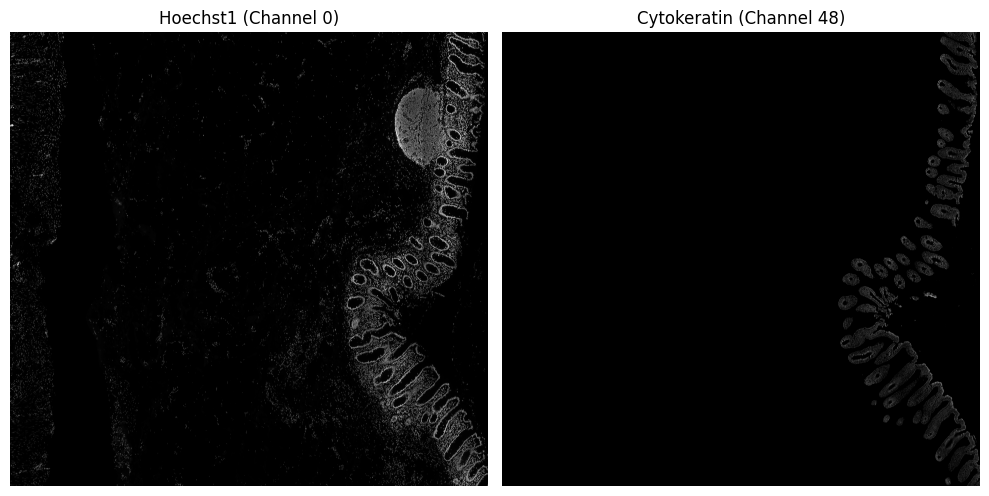

In [9]:
# Stack if needed for downstream model
selected = np.stack([hoechst1, cytokeratin], axis=0)  # shape: (2, 9510, 9993)

# Display both
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(hoechst1, cmap='grey')
axes[0].set_title("Hoechst1 (Channel 0)")
axes[0].axis("off")

axes[1].imshow(cytokeratin, cmap='grey')
axes[1].set_title("Cytokeratin (Channel 48)")
axes[1].axis("off")

plt.tight_layout()
plt.show()

> Note: this is not a normalized imae input. 


Final input image shape: (9510, 9993, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0..65535].


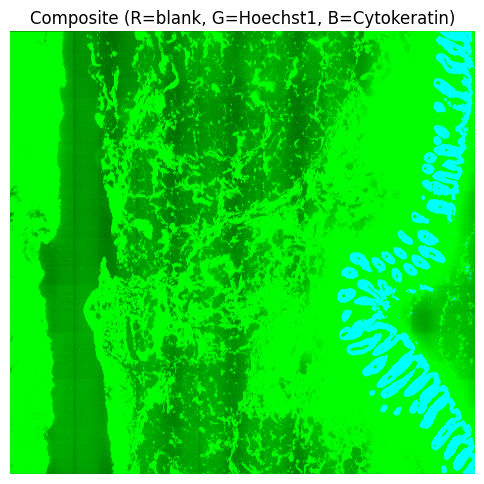

In [10]:
# --- Build the 3-channel CellSAM-compatible image ---
# Channel 0 (R): blank (zeros)
# Channel 1 (G): Hoechst1 (nuclear stain)
# Channel 2 (B): Cytokeratin (membrane stain)

blank_channel = np.zeros_like(hoechst1)
three_channel_img = np.stack([blank_channel, hoechst1, cytokeratin], axis=-1)

print("Final input image shape:", three_channel_img.shape)  # (9510, 9993, 3)

# Optional: visualize the composite RGB image
plt.figure(figsize=(6, 6))
plt.imshow(three_channel_img)
plt.title("Composite (R=blank, G=Hoechst1, B=Cytokeratin)")
plt.axis("off")
plt.show()

In [11]:
iio.imwrite('three_channel_img.tif', three_channel_img)

In [13]:
three_channel_img =iio.imread('three_channel_img.tif')

> For full details of the `cellsam_pipeline()` function, see the [CellSAM reference documentation](https://vanvalenlab.github.io/cellSAM/reference/generated/cellSAM.cellsam_pipeline.cellsam_pipeline.html#cellSAM.cellsam_pipeline.cellsam_pipeline).


**Note: The for this experiment we have kept the 'gauge_cell_size = True' but to avoid the computational overhead so it is suggested to use 'gauge_cell_size = False' just because just for a sample image it took us 100 minutes for the mask creation on 'True' mode**

Mean diff: 0.01125631108880043
0.027322179
Total blocks: 600


0it [00:00, ?it/s]/u/sbdubey/miniconda/envs/hra-deepcell/lib/python3.12/site-packages/cellSAM/sam_inference.py:351: UserWarning: Low IOU threshold, ignoring mask.
  warnings.warn("Low IOU threshold, ignoring mask.")
1it [00:10, 10.69s/it]/u/sbdubey/miniconda/envs/hra-deepcell/lib/python3.12/site-packages/cellSAM/sam_inference.py:351: UserWarning: Low IOU threshold, ignoring mask.
  warnings.warn("Low IOU threshold, ignoring mask.")
2it [00:18,  8.95s/it]/u/sbdubey/miniconda/envs/hra-deepcell/lib/python3.12/site-packages/cellSAM/sam_inference.py:351: UserWarning: Low IOU threshold, ignoring mask.
  warnings.warn("Low IOU threshold, ignoring mask.")
3it [00:23,  7.40s/it]/u/sbdubey/miniconda/envs/hra-deepcell/lib/python3.12/site-packages/cellSAM/sam_inference.py:351: UserWarning: Low IOU threshold, ignoring mask.
  warnings.warn("Low IOU threshold, ignoring mask.")
8it [00:29,  1.91s/it]/u/sbdubey/miniconda/envs/hra-deepcell/lib/python3.12/site-packages/cellSAM/sam_inference.py:351: User

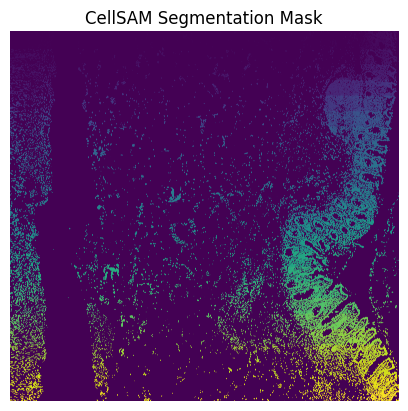

In [12]:
# Run inference pipeline
mask2 = cellsam_pipeline(
    three_channel_img, 
    use_wsi=True,
    low_contrast_enhancement=True,
    gauge_cell_size=False
)

# Visualize
plt.imshow(mask2)
plt.title("CellSAM Segmentation Mask")
plt.axis("off")
plt.show()

In [15]:
iio.imwrite('segmented_output45.tif', mask2)

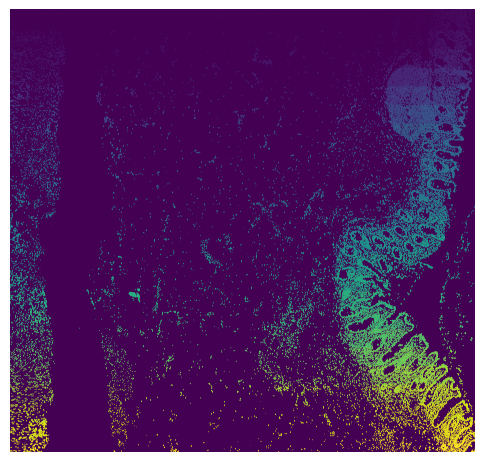

In [ ]:
# Read the image stack (all frames / z-slices)
segmented = iio.imread('segmented_output45.tif')
plt.figure(figsize=(6, 6))
plt.imshow(segmented)
plt.title("")
plt.axis("off")
plt.show()

In [15]:
print(f'the size of the image is {three_channel_img.shape}')

the size of the image is (9510, 9993, 3)


In [16]:
print("Shape of the segmented file is : ", segmented.shape)  # (9510, 9993, 3)

Shape of the segmented file is :  (9510, 9993)


# Deepcell Annotation 

In [17]:
import deepcell_types
import torch
import pandas as pd
from collections import defaultdict

In [18]:
if torch.cuda.is_available():
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"\nGPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"  Memory Allocated: {torch.cuda.memory_allocated(i)/1024**2:.2f} MB")
        print(f"  Memory Cached:    {torch.cuda.memory_reserved(i)/1024**2:.2f} MB")
else:
    print("No GPU detected.")

Number of GPUs: 2

GPU 0: NVIDIA RTX A5500
  Memory Allocated: 0.00 MB
  Memory Cached:    0.00 MB

GPU 1: NVIDIA RTX A5500
  Memory Allocated: 0.00 MB
  Memory Cached:    0.00 MB


In [24]:
# Model & system-specific configuration
model = "deepcell-types_2025-06-09"

# NOTE: if you do not have a cuda-capable GPU, try "cpu"
device = "cuda"
# NOTE: For machines with many cores & large RAM (e.g. GPU nodes), consider
# increasing for better performance.
num_data_loader_threads = 1

In [20]:
mpp = 0.37744

In [21]:
print(f'The shape of the input image is {img.shape}')

The shape of the input image is (54, 1, 9510, 9993)


In [22]:
img_update = np.squeeze(img)
print("Final trimmed shape:", img_update.shape)


Final trimmed shape: (54, 9510, 9993)


In [25]:
cell_types = deepcell_types.predict(
    img_update,
    segmented,
    channels,
    mpp,
    model_name=model,
    device_num=device,
    num_workers=num_data_loader_threads,
)

/u/sbdubey/miniconda/envs/celltools10g/lib/python3.12/site-packages/deepcell_types/dataset.py:42: UserWarning: Channel Hoechst1 is not in the channel mapping. This channel will be masked out.
  warnings.warn(
/u/sbdubey/miniconda/envs/celltools10g/lib/python3.12/site-packages/deepcell_types/dataset.py:42: UserWarning: Channel CDX2 is not in the channel mapping. This channel will be masked out.
  warnings.warn(
/u/sbdubey/miniconda/envs/celltools10g/lib/python3.12/site-packages/deepcell_types/dataset.py:42: UserWarning: Channel NKG2D is not in the channel mapping. This channel will be masked out.
  warnings.warn(
/u/sbdubey/miniconda/envs/celltools10g/lib/python3.12/site-packages/deepcell_types/dataset.py:42: UserWarning: Channel Synaptophysin is not in the channel mapping. This channel will be masked out.
  warnings.warn(
/u/sbdubey/miniconda/envs/celltools10g/lib/python3.12/site-packages/deepcell_types/dataset.py:42: UserWarning: Channel aSMA is not in the channel mapping. This channe

In [26]:
idx_to_pred = dict(enumerate(cell_types, start=1))

pd.DataFrame.from_dict(  # For nice table rendering
    idx_to_pred, orient="index", columns=["Cell type"]
)

,Cell type
1,SmoothMuscle
2,SmoothMuscle
3,SmoothMuscle
4,SmoothMuscle
5,Enterocyte
...,...
33628,LymphaticEndothelial
33629,Enterocyte
33630,Enterocyte
33631,Enterocyte


In [29]:
# --- First output: per-cell type labels ---

# Convert to DataFrame with correct column names
df_cell_types = pd.DataFrame(list(idx_to_pred.items()), columns=["Cell_ID", "Cell_Name"])

# Save to CSV
df_cell_types.to_csv("deepcell_type_label.csv", index=False)
print("✅ Saved per-cell labels → deepcell_type_label.csv")

✅ Saved per-cell labels → deepcell_type_label.csv


In [ ]:
# Convert the 1-1 `cell: type` mapping to a 1-many `type: list-of-cells` mapping
labels_by_celltype = defaultdict(list)
for idx, ct in idx_to_pred.items():
    labels_by_celltype[ct].append(idx)

In [28]:
from pprint import pprint

print(f"Total number of cells: {(num_cells := np.max(segmented))}")

pprint(
    {
        k: f"{len(v)} ({100 * len(v) / num_cells:02.2f}%)"
        for k, v in labels_by_celltype.items()
    },
    sort_dicts=False,
)

Total number of cells: 93561
{'SmoothMuscle': '8522 (9.11%)',
 'Enterocyte': '5375 (5.74%)',
 'ICC': '1217 (1.30%)',
 'BloodVesselEndothelial': '4424 (4.73%)',
 'Paneth': '326 (0.35%)',
 'LymphaticEndothelial': '3286 (3.51%)',
 'CD8T': '922 (0.99%)',
 'Macrophage': '1132 (1.21%)',
 'Neutrophil': '446 (0.48%)',
 'CD4T': '1632 (1.74%)',
 'Dendritic': '489 (0.52%)',
 'Goblet': '1586 (1.70%)',
 'Plasma': '2216 (2.37%)',
 'Endocrine': '484 (0.52%)',
 'NK': '258 (0.28%)',
 'Mesangial': '5 (0.01%)',
 'Microglial': '50 (0.05%)',
 'Bcell': '1237 (1.32%)',
 'Glial': '17 (0.02%)',
 'Langerhans': '1 (0.00%)',
 'Stromal': '3 (0.00%)',
 'CollectingDuct': '3 (0.00%)',
 'Hepatocyte': '1 (0.00%)'}


In [30]:
# --- Create and save the summary table ---
pop_summary = {
    k: {"Cell_Count": len(v), "Percentages": 100 * len(v) / num_cells}
    for k, v in labels_by_celltype.items()
}

df_population = (
    pd.DataFrame.from_dict(pop_summary, orient="index")
    .reset_index()
    .rename(columns={"index": "Cell_type"})
    .sort_values("Cell_Count", ascending=False)
)

# Round percentages for readability
df_population["Percentages"] = df_population["Percentages"].round(2)

# Save to CSV
df_population.to_csv("deepcell_population.csv", index=False)

In [31]:
# Optional: quick preview
print(df_population.head())

                 Cell_type  Cell_Count  Percentages
0             SmoothMuscle        8522         9.11
1               Enterocyte        5375         5.74
3   BloodVesselEndothelial        4424         4.73
5     LymphaticEndothelial        3286         3.51
12                  Plasma        2216         2.37
